In [1]:
# En esta celda irán todas las paqueterías necesarias para este notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import multiprocessing
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
# En esta celda irán todas las funciones necesarias para este notebook.

### Function made on a personal project in my home university in México
def dqr(data):
    #Lista de variables (features) de la de datos
    columns = pd.DataFrame(list(data.columns.values),columns=['Nombres'], index=list(data.columns.values))

    #Lista de tipos de datos
    data_types=pd.DataFrame(data.dtypes, columns=['Data_Types'])

    #Lista de datos perdidos (missing data)
    missing_values=pd.DataFrame(data.isnull().sum(),columns=['missing_values'])

    #Lista de los datos presentes
    present_values=pd.DataFrame(data.count(),columns=['present_values'])

    #Lista de valores únicos
    unique_values=pd.DataFrame(columns=['unique_values'])
    for col in list(data.columns.values):
        unique_values.loc[col]=[data[col].nunique()]

    #Lista de valores mínimos
    min_values = pd.DataFrame(columns=['min'])
    for col in list(data.columns.values):
        try:
            min_values.loc[col]=[data[col].min()]
        except:
            pass

    #Lista de valores mínimos
    max_values = pd.DataFrame(columns=['max'])
    for col in list(data.columns.values):
        try:
            max_values.loc[col]=[data[col].max()]
        except:
            pass
        
    #Regresar el reporte con la union de todos los dataframes
    return columns.join(data_types).join(missing_values).join(present_values).join(unique_values).join(min_values).join(max_values)

def boxplots_cols(dataset, columns_list, rows: 'número de filas', cols:'número de columnas'):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def hist_cols(dataset, columns_list, rows, cols):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(10,30))
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        axs[i].hist(dataset[data].dropna())  
        axs[i].set_title(data)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_model(X, Y, model):
    global scores
    yhat = model.predict(X)
    cnf_matrix = confusion_matrix(Y, yhat, labels=[0,1])
    np.set_printoptions(precision=2)

    report = classification_report(Y, yhat)
    #print(report)
    #Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No fraude(0)','Fraude(1)'],normalize= False,  title='Confusion matrix')
    plt.show()
    
    TP = cnf_matrix[1][1]
    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    
    accuracy = (TP + TN) / cnf_matrix.sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_scoree = TP / (TP + (0.5 * (FP + FN)))
    
    #f1 = f1_score(Y, yhat)
    
    dfr = pd.DataFrame(data = {'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall,
                              'F1 Score': f1_scoree}, index = ['Resultado'])
    
    print(dfr)

    return yhat

def AUCROC(X, y, model):
    y_pred_proba = model.predict_proba(X)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = "AUC = " + str(round(auc, 4)))
    plt.plot([0,1], [0,1], 'r--')
    plt.legend(loc = 'best')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Prueba DS 2024 - Pablo Rivera

La empresa necesita realizar un modelo de fraude. Tu papel como DS es dar una solución de modelo y mitigar los riesgos de fraude basada en datos. Los datos para realizar el modelo son datos_fraud.csv y los pasos a seguir serán los siguientes. 

- Cleaning and Exploratory Data Analysis
- Data Preparation/Pre-processing 
- Data Training
- Data Testing and Metrics
- Extras 
- Conclusiones


# Cleaning and Exploratory Data Analysis

En esta sección se analizará qué tan limpia está la base de datos, qué modificaciones se le pueden hacer para que esté limpia y también se realizará un análisis exploratorio para conocer las características de las variables.

In [3]:
# Cargar los datos
data = pd.read_csv('datos_fraud.csv')
data.shape

(284807, 36)

In [4]:
# Data Qualiry Report de los datos
dqr(data)

,Nombres,Data_Types,missing_values,present_values,unique_values,min,max
transaction_id,transaction_id,object,0,284807,283726,00003e4793d4bda49e0dded585e3d32b5a46e673984828...,fffffd215ec2c3b413083581627bb6fdba5f823392d613...
timestamp,timestamp,float64,0,284807,124592,0.0,172792.0
amount,amount,float64,0,284807,32767,0.0,25691.16
variable_01,variable_01,float64,0,284807,275663,-15.430084,33.847808
variable_02,variable_02,float64,0,284807,275663,-22.565679,31.612198
variable_03,variable_03,float64,0,284807,275663,-2.604551,3.517346
variable_04,variable_04,float64,0,284807,275663,-10.295397,7.519589
variable_05,variable_05,float64,0,284807,275663,-2.836627,4.584549
variable_06,variable_06,float64,0,284807,275663,-44.807735,22.528412
variable_07,variable_07,float64,0,284807,275663,-10.933144,10.50309


Al analizar el reporte de calidad de datos, nos podemos dar cuenta de que los datos están relativamente limpios; no existen valores nulos en ninguna columna, solo hay que revisar que no existan valores duplicados con la siguiente parte del código.

De igual manera, si nos fijamos en los máximos y mínimos, podemos observar que puede haber algunos datos outliers. Esto se analizará un poco más adelante en el notebook.

In [5]:
# Valores duplicados de los datos
data[data.duplicated(keep=False)]

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,...,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud
34,12019862d3ae28c22e8872bc680756529af41cc8dac3c3...,119968.0,1.00,-1.155874,-1.476704,0.094501,0.230873,-0.849740,-0.858527,1.787127,...,3.353437,1.138297,-0.099684,0.896565,-0.130796,0.321305,-4.492574,-15.257540,-4.725452,0
36,d4c08ffe5bf53cde213abf9debb6c094c857bea4933d7a...,93879.0,30.31,-0.711066,-2.498300,-0.167808,-0.743909,0.519952,-0.412861,-0.266162,...,-11.731476,10.648505,-18.256576,7.352148,-13.086519,-0.570548,-14.750615,-9.386073,-7.994561,1
37,f75c35a5b81b38e308ff4dead1dd12cd1d3653a88117aa...,145.0,6.00,0.119831,-0.188281,-0.313703,0.239603,-1.724222,0.006927,-1.238620,...,-0.281518,0.983069,0.553646,1.947885,-2.420413,-1.066590,-1.159201,1.581769,-0.602499,0
186,e7a755a2ebea3c9997b11202f32a854044fafcae052dc8...,38359.0,84.00,0.036264,0.038424,-0.156100,0.376851,0.679782,-0.055733,0.799671,...,-1.366925,-0.385175,0.904888,-0.805808,1.159396,-0.530740,0.685023,0.478685,0.122956,0
637,4a469cca8debbabbac141a01cd21059241eba0f2c9f244...,35051.0,13.31,-0.092576,-0.508713,-0.385041,0.185365,0.107832,-0.116768,0.168676,...,-0.575592,0.861128,0.426090,1.739129,-1.867735,-1.309140,-0.793976,-1.222001,-1.627881,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284304,4394928b4d55ff79338b2d78b1f3f62776e12066bf3e1c...,92810.0,50.56,-0.242442,-0.836394,-0.248880,1.186632,-0.092886,-0.415445,0.165777,...,-0.347648,1.187927,-0.693910,2.773234,-2.152857,-0.846192,-1.209319,-3.200235,-2.676461,0
284408,47ff22377542d4cca5512310da9b78e84f0fdec71d55c5...,117527.0,1.00,-0.087946,-0.063814,-0.215089,0.936472,0.239556,-0.263168,1.028704,...,1.413376,0.952109,-2.630035,0.373995,2.110122,-0.731302,-0.716341,-1.160884,-0.204203,0
284432,4f36bd59447b043447dc0463b3b8126f91d5f44e0354de...,146617.0,38.47,0.391020,-0.347709,-1.314999,-0.072449,-0.574646,0.031561,-1.195722,...,0.842058,-0.312521,1.337735,0.244651,-1.527505,-4.470998,0.395671,5.161461,-1.112670,0
284662,9bfbcc2951e2d3dfd9f13865aacf37fb2c7340eed581c9...,42456.0,6.03,0.018120,-0.000483,-0.180947,0.379254,0.525207,0.064197,-0.394751,...,-0.229004,2.545111,0.913334,0.528636,1.111271,-0.615218,0.730830,0.239184,-0.001545,0


In [6]:
# Eliminar valores duplicados, tomando únicamente la primer repetición del dato
data.drop_duplicates(keep = 'first', inplace = True)
data.shape

(283726, 36)

In [7]:
# Si volvemos a obtener los duplicados vemos que ya no hay ninguno
data[data.duplicated(keep=False)]

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,...,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud


Con lo anterior podemos ver que los datos duplicados han sido eliminados, ahora se analizará la posible existencia de outliers en los datos.

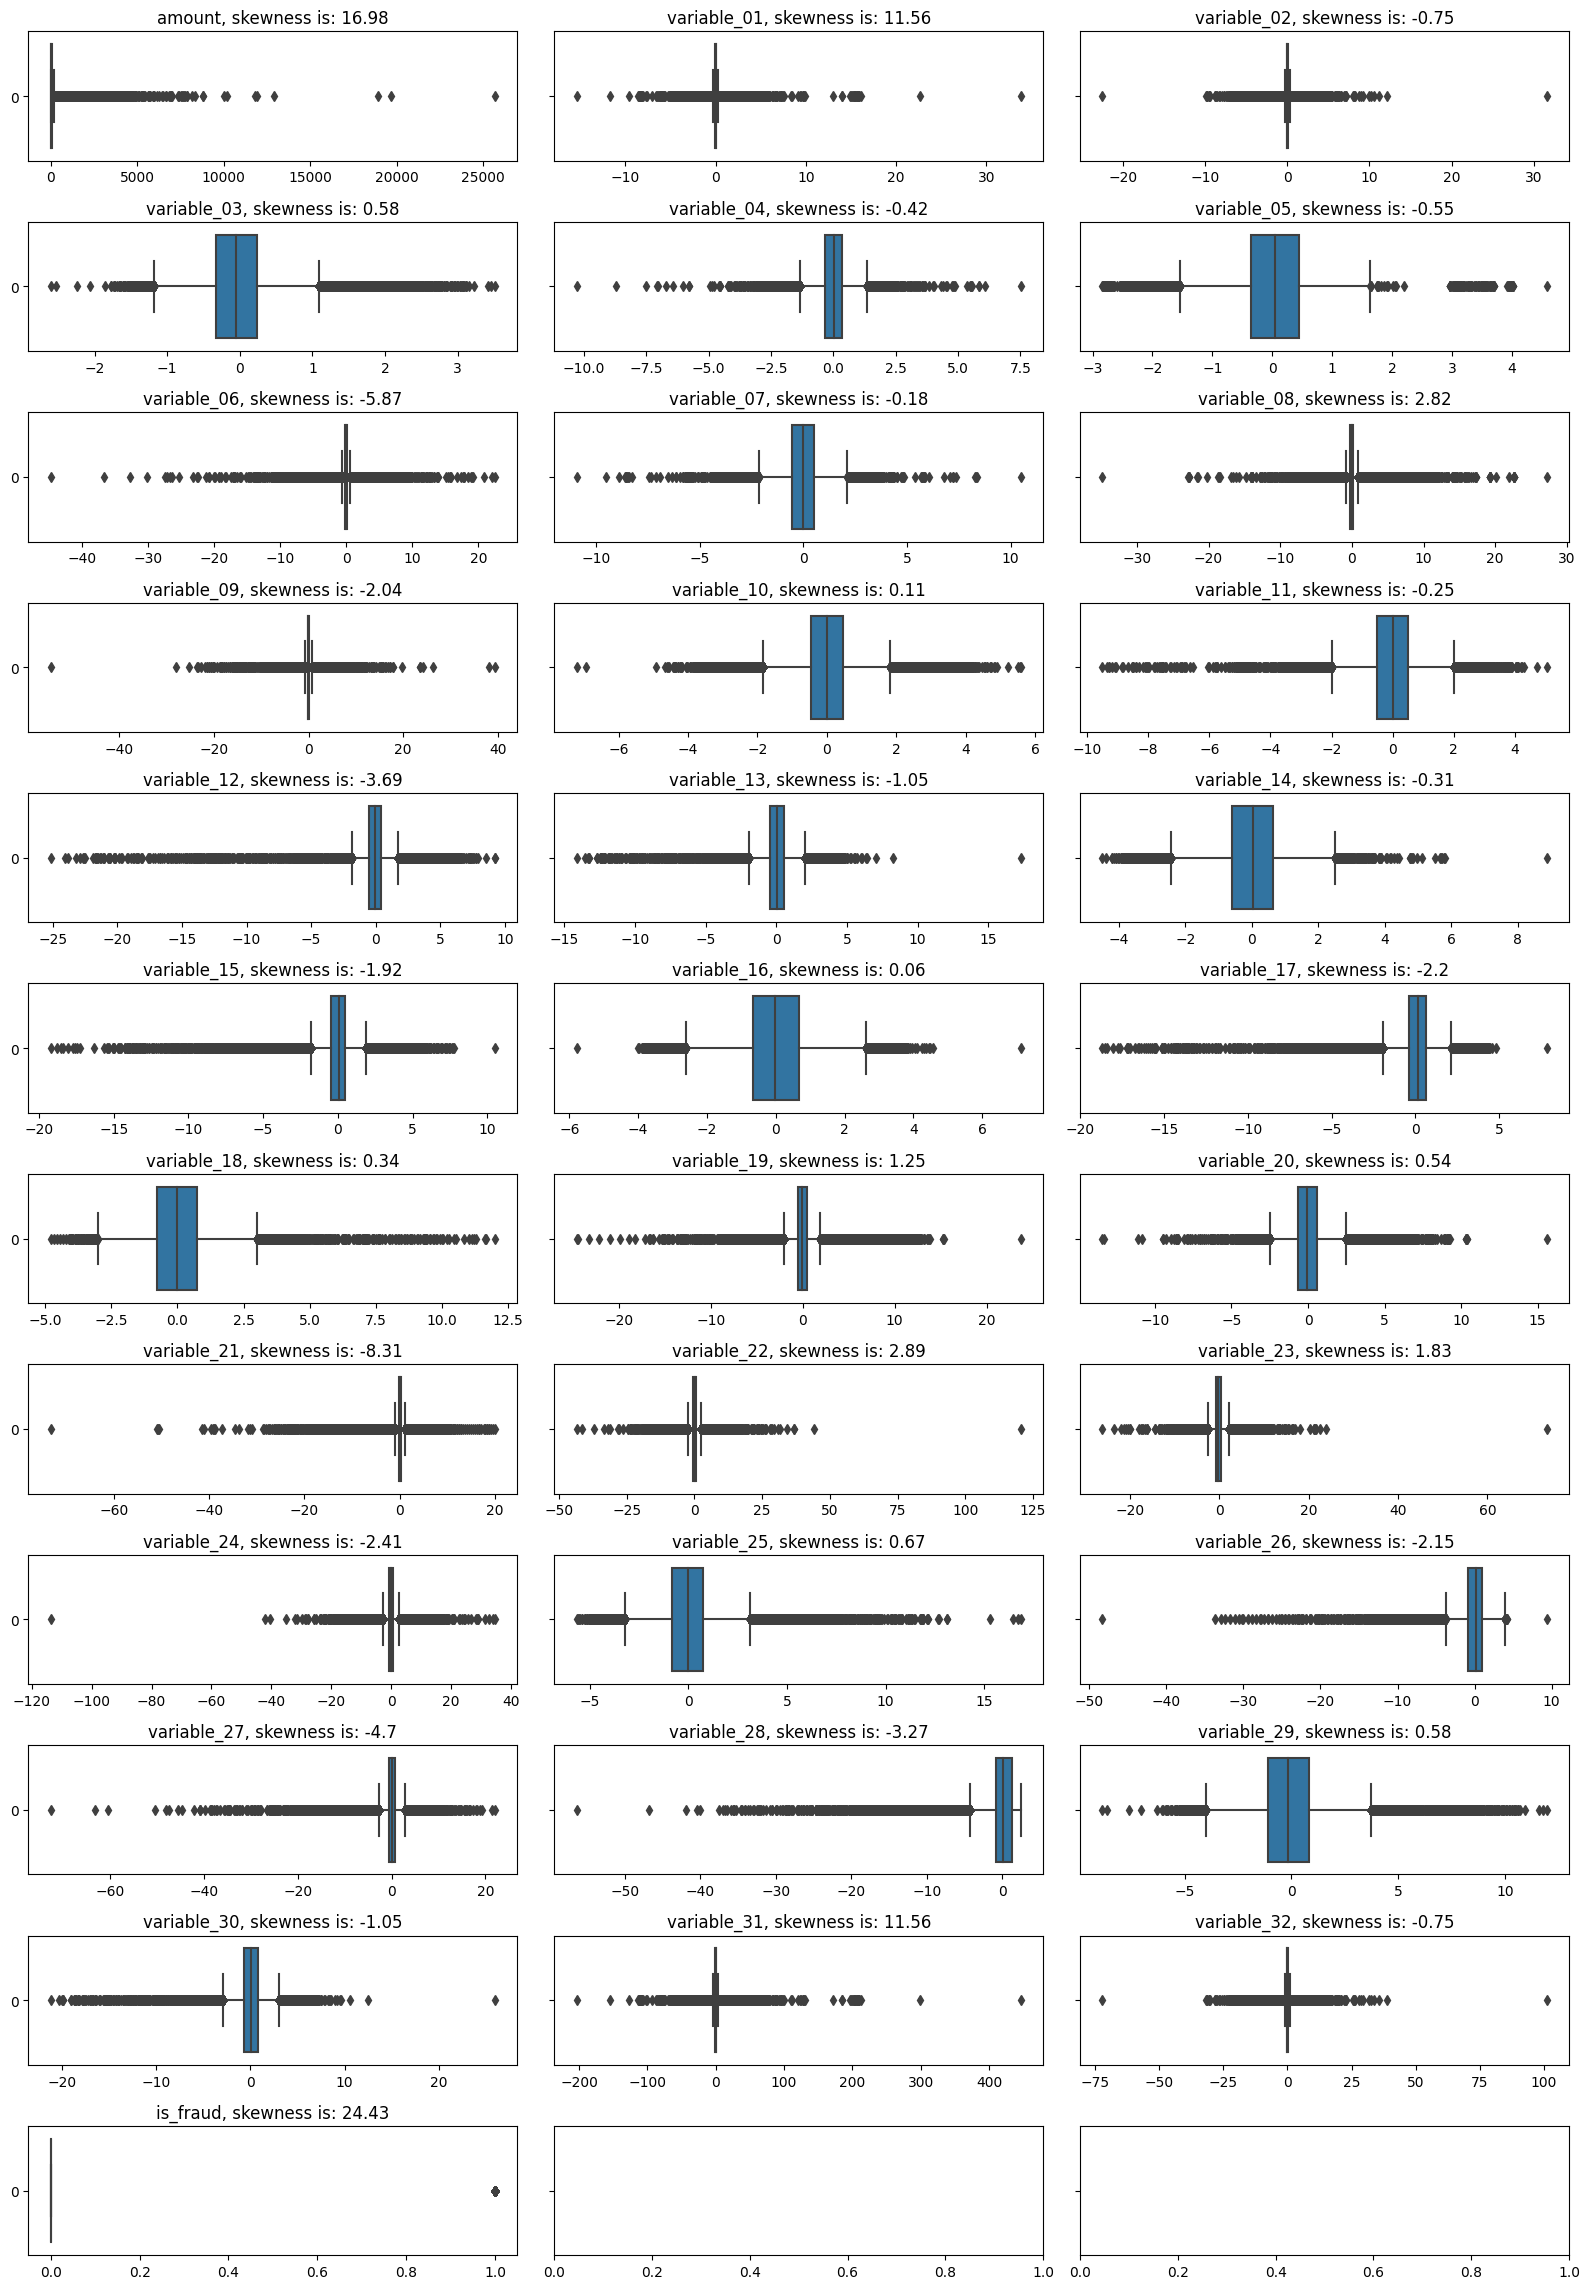

In [8]:
# Función para crear boxplots de todas las columnas
boxplots_cols(data, data.columns[2:], 12, 3)

Como podemos observar, casi todas, si no es que todas, las variables cuentan con bastantes outliers. Podemos eliminar dichos outliers con diferentes técnicas, como por ejemplo, usando el Interquartile Range (IQR). Sin embargo, en este notebook se trabajará con todos los datos sin tratar de solucionar este problema debido a cuestiones de tiempo.

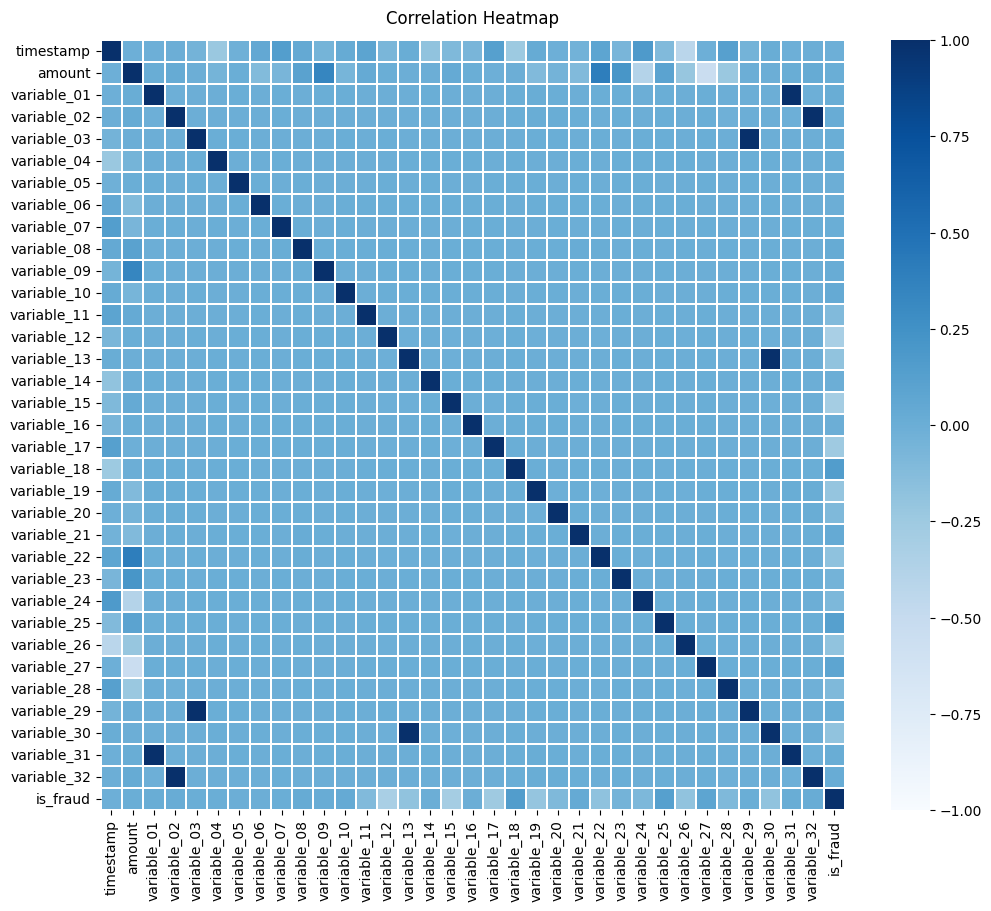

In [9]:
# Creación de heatmap para analizar correlación entre variables
plt.figure(figsize = (12, 10))
heatmap = sns.heatmap(data.corr(), vmin = -1, vmax = 1, cmap = "Blues", linewidths = 0.01, linecolor = 'white')
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize': 12}, pad = 12);
plt.show()

Al analizar la matriz de correlaciones de todos los datos, podemos observar que hay 4 combinaciones de variables que tienen una correlación de 1, es decir, tienen una correlación positiva perfecta. Estas variables son:

- Variable 1 con variable 31
- Variable 2 con variable 32
- Variable 3 con variable 29
- Variable 13 con variable 30

Por lo tanto, se eliminarán las variables 29 a 32 debido a que son redundantes, tienen la misma información que las otras variables, por lo que mantenerlas podría causar problemas al momento de crear nuestro modelo. 

In [10]:
# Eliminar variables con correlación positiva perfecta
data.drop(['variable_29', 'variable_30', 'variable_31', 'variable_32'], axis = 1, inplace = True)
data

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,is_fraud
0,99899e9e02c4b41fc442744220e6fa12f8d36b26f70027...,155270.0,12.00,-0.071330,-0.032900,0.109989,0.339889,-0.626131,-0.116853,1.220826,...,-0.635935,-0.445327,-0.251412,-0.989219,-0.168169,-1.054944,-1.603176,-0.616640,2.283078,0
1,d678605da2ed45d14c95228b2e6a0daa1c635c7c5d3f7c...,46054.0,208.89,0.057858,0.003669,0.076745,0.392782,0.458835,-0.279094,0.435257,...,2.034140,-0.073293,-0.439827,-0.863551,-1.606923,-1.100937,0.597263,-1.228029,0.875399,0
2,5f178ebbecf592c3ea98b5b26ff3547f8a40e88aa428d5...,167866.0,1.00,-0.002449,0.019520,-0.038565,0.400659,-1.214922,-0.177434,0.303247,...,0.561721,-0.351699,0.362076,-1.215083,1.044934,0.533274,-2.802382,0.570268,2.121604,0
3,455543a8012484e430efd18300186319bf8da376811333...,163539.0,15.00,-0.039202,-0.031762,-0.328682,-0.045094,0.606368,0.204822,0.014322,...,-0.791305,-0.159512,-0.300838,-0.787018,0.020468,-0.853713,-1.915028,-0.478400,2.161957,0
4,d8637ef4c5c833fee92149b5b8ef2fad601196be9b7c89...,153872.0,0.01,-0.058206,-0.051926,0.653525,-0.387901,0.806301,0.227390,0.676840,...,1.449330,0.141885,-0.854064,-0.347373,-0.750013,-0.914675,-0.595874,-0.705751,2.026529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,6839bb4827bdb57913b40b437fa23298f5239ffcbebfc2...,67750.0,20.95,-0.069132,0.188023,-0.316651,0.128033,-0.322301,-0.043339,0.201194,...,-0.674360,0.974583,-0.461203,0.675453,-0.113343,0.775532,1.775175,0.739190,-1.213954,0
284803,f26fc92e5f72568622421ba00fd4b9deb0dd3dfcbb4a3b...,44849.0,270.00,0.069018,-0.015243,-0.050520,0.210760,0.418322,-0.230815,-0.086388,...,2.140847,-0.028005,-0.407734,-0.870850,-1.751646,-1.033579,0.546490,-1.471844,0.753390,0
284804,238cdd7705d3b8306ba773849ea6345ca58a21f7c1914d...,117797.0,28.32,-0.265292,-1.056264,0.979528,0.782035,0.692832,-0.388238,0.948950,...,0.045188,-0.285031,0.708199,-0.328988,0.861190,0.150386,0.427417,0.641439,-1.906318,0
284805,0b243a55869df946b3b78f84ec5554da161f89a1181c12...,167436.0,256.58,0.093611,0.051865,-0.410531,0.685550,-0.965304,0.269152,0.990574,...,0.590212,1.086074,-0.264151,2.972262,0.807602,-0.016152,2.330076,-1.272419,-2.035372,0


Ya habiendo eliminado dichas variables, veremos la distribución de las restantes.

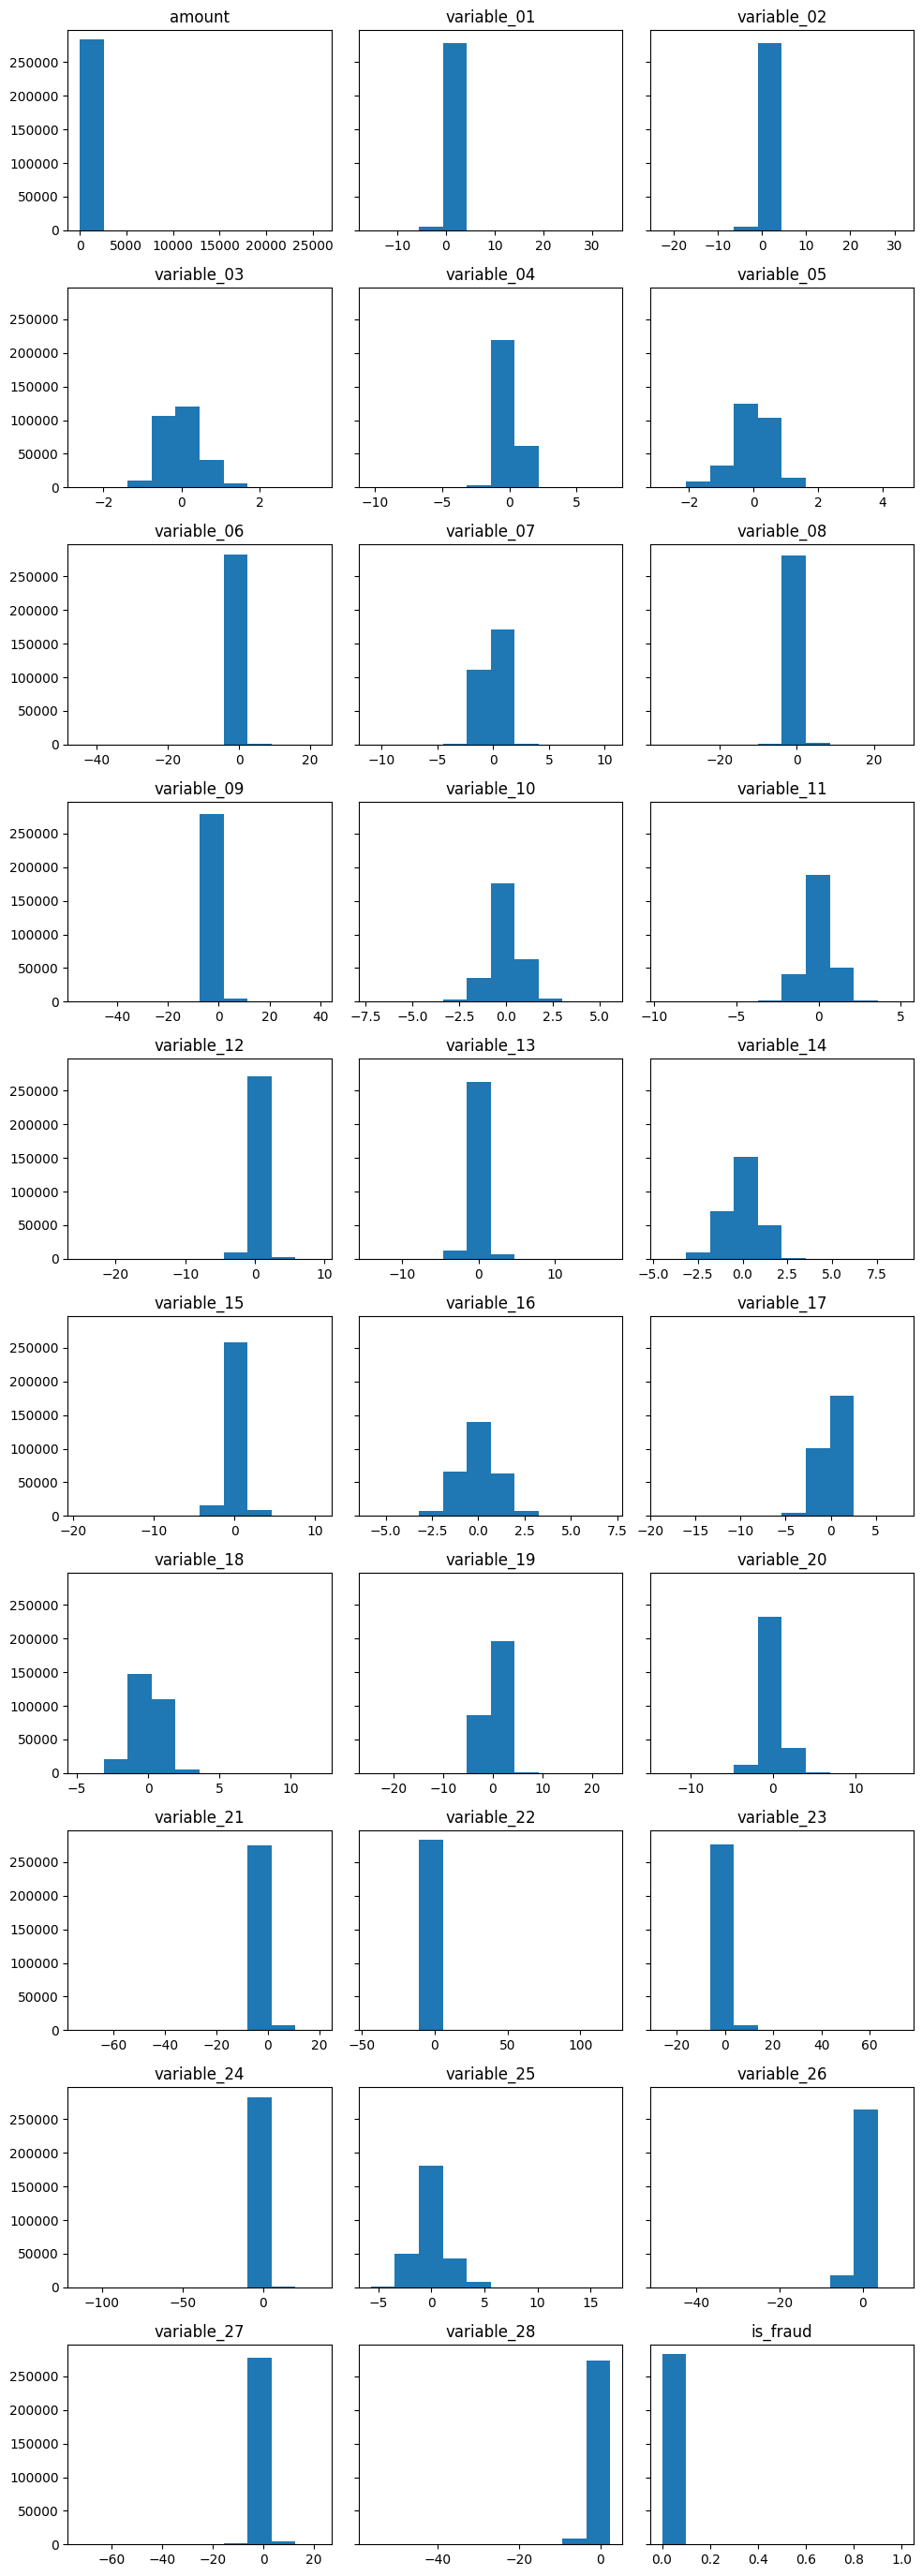

In [11]:
# Función para visualizar histogramas de todas las variables
hist_cols(data, data.columns[2:], 10, 3)

Las distribuciones de cada variable parecen ser normales, son diferentes entre sí y todos los valores parecen centrarse cerca del cero. 

In [12]:
# Estadísticas de los datos
data.describe()

,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,is_fraud
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,88.472687,0.000547,0.001763,0.000149,-0.000232,0.000214,0.000198,-0.000015,-0.000371,...,-0.001596,-0.000854,0.001801,-0.001139,0.001828,-0.002966,0.001613,-0.004135,0.005917,0.001667
std,47481.047891,250.399437,0.328027,0.395744,0.482053,0.521220,0.605627,0.623702,0.724550,0.723909,...,1.095492,1.179054,1.227664,1.331931,1.377008,1.414184,1.508682,1.646703,1.948026,0.040796
min,0.000000,0.000000,-15.430084,-22.565679,-2.604551,-10.295397,-2.836627,-44.807735,-10.933144,-34.830382,...,-13.434066,-73.216718,-43.557242,-26.160506,-113.743307,-5.683171,-48.325589,-72.715728,-56.407510,0.000000
25%,54204.750000,5.600000,-0.052818,-0.070641,-0.326763,-0.317485,-0.354453,-0.161703,-0.542700,-0.228305,...,-0.644221,-0.208828,-0.552509,-0.769031,-0.689830,-0.850134,-0.889682,-0.600321,-0.915951,0.000000
50%,84692.500000,22.000000,0.011288,0.001479,-0.052172,0.016278,0.041016,-0.011159,0.006675,-0.029441,...,-0.052596,0.021898,0.040859,-0.275168,-0.053468,-0.022248,0.179963,0.063949,0.020384,0.000000
75%,139298.000000,77.510000,0.078276,0.091208,0.240261,0.350667,0.439738,0.147748,0.528245,0.186194,...,0.595977,0.325704,0.570474,0.396792,0.612218,0.739647,1.026960,0.800283,1.316068,0.000000
max,172792.000000,25691.160000,33.847808,31.612198,3.517346,7.519589,4.584549,22.528412,10.503090,27.202839,...,15.594995,20.007208,120.589494,73.301626,34.801666,16.875344,9.382558,22.057729,2.454930,1.000000


La tabla anterior muestra estádisticas básicas de todas las variables, a continuación se analizará si existe un desbalance en los datos.

In [13]:
# Filtrar los datos de acuerdo a si son fraude (1) o si no son fraude (0)
data_fraud = data[data['is_fraud'] == 1]
data_clean = data[data['is_fraud'] == 0]

len(data_fraud), len(data_clean)

(473, 283253)

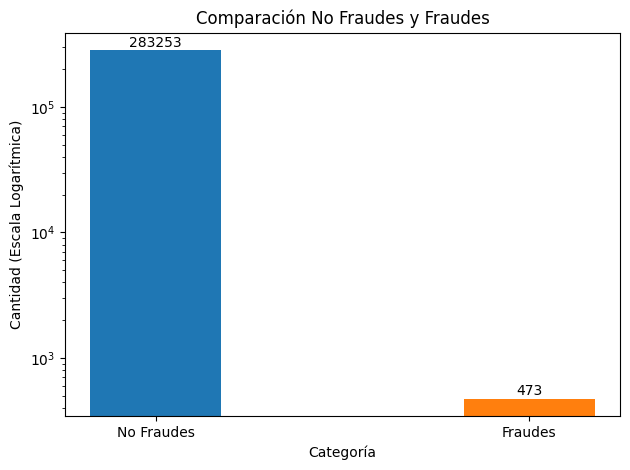

In [14]:
# Gráfica mostrando la cantidad de fraudes y no fraudes
fig, ax = plt.subplots()
bars1 = ax.bar('No Fraudes', len(data_clean), width = 0.35)
bars2 = ax.bar('Fraudes', len(data_fraud), width = 0.35)

ax.set_yscale('log')

ax.bar_label(bars1, labels=[f'{len(data_clean)}'], padding=0.5)
ax.bar_label(bars2, labels=[f'{len(data_fraud)}'], padding=0.5)

ax.set_title('Comparación No Fraudes y Fraudes')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad (Escala Logarítmica)')

fig.tight_layout()
plt.show()

La gráfica anterior nos muestra otro pequeño problema con los datos, y es que están desbalanceados, teniendo solamente 473 transacciones fraudulentas mientras que hay alrededor de 283,000 transacciones limpias. Esto puede presentar problemas al momento de crear los modelos así como al momento de evaluar su desempeño, por lo que este desbalance será solucionado más adelante en el notebook.

# Data Preparation/Pre-processing

Para solucionar el problema del desbalance de datos, hay varios métodos, como pueden ser el over-sampling y el under-sampling. Over-sampling y under-sampling son las opciones más sencillas, sin embargo, ambas tienen sus ventajas y desventajas, como podrían ser crear datos artificiales en el caso de over-sampling, así como la pérdida de información en under-sampling.


Existe otra alternativa llamada SMOTE la cual, en pocas palabras, es una combinación de ambas. Sin embargo, en este caso se utilizará under-sampling, tomando un ratio/peso de los datos que son minoría para obtener un sample de la categoría con más datos de la misma longitud que la minoría, en este caso que las transacciones fraudulentas. En la parte de extras se explorará la alternativa de utilizar SMOTE.

In [15]:
# Ratio para obtener una muestra de la mayoría equivalente a la minoría
ratio_samples = len(data_fraud)/len(data_clean)
ratio_samples

0.0016698852262818046

In [16]:
# Muestras (under-sampling) de la clase mayoritaria
muestra_clean = data_clean.sample(frac = ratio_samples, random_state=10) 
muestra_clean

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,is_fraud
194124,7b02919033d6ef7cb7b647739d4ef5c2eae5a0216d70d4...,127111.0,31.00,-0.040171,0.030864,-0.808555,0.142123,-0.012599,0.170721,-0.760938,...,1.176565,0.047958,-0.086096,0.449408,0.364603,1.397919,-1.121016,-0.227315,1.960035,0
138609,e2eea5d465528cd8ba49e577714b70a733f56ad4cbe2fd...,33186.0,126.00,0.023076,-0.037582,0.424991,0.384229,-0.409512,-0.123109,-0.551438,...,0.508030,0.006230,0.033143,0.088261,-0.246402,0.672836,0.138874,-0.389983,1.001255,0
140529,720e1d357d97c74bfa5dfec3c1b60e567459cbb3cc4e23...,121114.0,0.76,-0.024899,-0.092447,0.662398,0.329132,0.564887,-0.036681,0.037387,...,-0.074152,-0.280731,0.650431,-1.378740,1.185474,0.622999,-3.178881,0.573322,2.062664,0
212540,007a29aafeb19ae0d5beca5f69c75a92b1781f9743d1cb...,164199.0,11.90,-0.086950,0.038593,0.592786,-0.273153,-1.807645,0.183511,0.585605,...,-0.776670,0.394531,-0.698714,1.563143,0.495150,-0.522570,-1.384392,-0.840887,1.955929,0
132790,50d9e8da1c7a886f713500ee9705bd57c1a9d4fadd961d...,166172.0,36.18,-0.185077,0.354865,0.400222,-1.033213,0.083267,0.560866,1.658681,...,-0.707304,0.200086,1.214683,-2.137301,0.889817,0.011493,-2.708035,0.239811,-1.393961,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227833,fcab3c5125757cfc979200fc97824c2ecd1f6417744254...,58000.0,1.00,0.010839,-0.007717,-0.296109,0.854102,0.401378,-0.145544,0.067366,...,-0.280864,-0.356160,0.552349,-1.191106,0.040666,1.105671,-0.113850,0.504610,1.278492,0
41734,fe9f610fe985bd84aebe960ff61ddc1c15289ae74ce4db...,81383.0,40.00,0.103502,0.422538,1.051432,0.410423,1.035089,-0.058043,-1.430104,...,0.226311,-0.222042,-1.697393,4.888337,0.924853,-2.345031,1.217815,-0.204636,-1.365061,0
33747,2469c4a37e64ca503c307c1a10bfbf5c35414b71613ca3...,11878.0,18.00,-0.044553,0.220725,-0.038993,0.732168,-0.323576,-0.429480,0.488847,...,2.679181,-0.077273,0.236750,-0.206788,0.068665,-2.728104,2.201803,0.301384,-1.195723,0
74634,d8e750204fd360ab31b8624e2ad69ed551cfd288d07a84...,121598.0,116.00,-0.041910,-0.027907,0.724592,-0.405339,-0.367131,0.082657,0.210562,...,-0.021345,0.078895,-1.028704,0.015997,-1.215433,-0.378215,-0.489951,-1.373632,1.874756,0


In [17]:
# Agregamos la muestra de la clase mayoritaria al DataFrame de la clase minoritaria
muestras = pd.concat([muestra_clean, data_fraud])
muestras.drop(['timestamp'], inplace = True, axis = 1)
muestras

,transaction_id,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,is_fraud
194124,7b02919033d6ef7cb7b647739d4ef5c2eae5a0216d70d4...,31.00,-0.040171,0.030864,-0.808555,0.142123,-0.012599,0.170721,-0.760938,-0.372018,...,1.176565,0.047958,-0.086096,0.449408,0.364603,1.397919,-1.121016,-0.227315,1.960035,0
138609,e2eea5d465528cd8ba49e577714b70a733f56ad4cbe2fd...,126.00,0.023076,-0.037582,0.424991,0.384229,-0.409512,-0.123109,-0.551438,-0.172512,...,0.508030,0.006230,0.033143,0.088261,-0.246402,0.672836,0.138874,-0.389983,1.001255,0
140529,720e1d357d97c74bfa5dfec3c1b60e567459cbb3cc4e23...,0.76,-0.024899,-0.092447,0.662398,0.329132,0.564887,-0.036681,0.037387,-0.027866,...,-0.074152,-0.280731,0.650431,-1.378740,1.185474,0.622999,-3.178881,0.573322,2.062664,0
212540,007a29aafeb19ae0d5beca5f69c75a92b1781f9743d1cb...,11.90,-0.086950,0.038593,0.592786,-0.273153,-1.807645,0.183511,0.585605,-0.077422,...,-0.776670,0.394531,-0.698714,1.563143,0.495150,-0.522570,-1.384392,-0.840887,1.955929,0
132790,50d9e8da1c7a886f713500ee9705bd57c1a9d4fadd961d...,36.18,-0.185077,0.354865,0.400222,-1.033213,0.083267,0.560866,1.658681,0.536355,...,-0.707304,0.200086,1.214683,-2.137301,0.889817,0.011493,-2.708035,0.239811,-1.393961,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281556,5b64a52c33e5d482fdffa62d1469d8debf93de5eb1d2c5...,3.79,0.309064,0.589595,0.117363,0.808783,0.279895,-0.165442,-0.108002,0.345921,...,-1.657635,0.472988,-2.279807,-0.789813,-1.186794,4.028571,-1.519650,1.636778,0.315642,1
282593,7b5475113aff30d043ce898f03f773952049f38316b3d5...,11.38,0.315645,1.411047,0.164709,-0.053390,0.625250,-0.014095,0.033922,2.153755,...,-6.557760,4.635798,-11.508842,-2.382711,-7.237464,8.174825,-8.451410,4.960892,-7.334341,1
283533,b353613b65b6a9caa7285413a8c9a0f9b1d8d2cdad6ff1...,3.79,0.054254,0.012948,-0.118941,0.350182,0.167608,0.077614,-0.800852,-0.423554,...,0.860044,-0.010874,-0.022989,-0.221981,0.175739,3.170258,0.394684,0.898474,1.088375,1
283985,e4ad01d776e0960c465876b3258849563645452b16eaa4...,1.00,0.359492,1.505516,-0.165797,-0.405520,-0.446891,-1.211123,0.175331,1.177852,...,-3.073079,2.373550,-7.934389,-2.683286,-1.698320,5.159401,-6.312782,0.577610,-5.753852,1


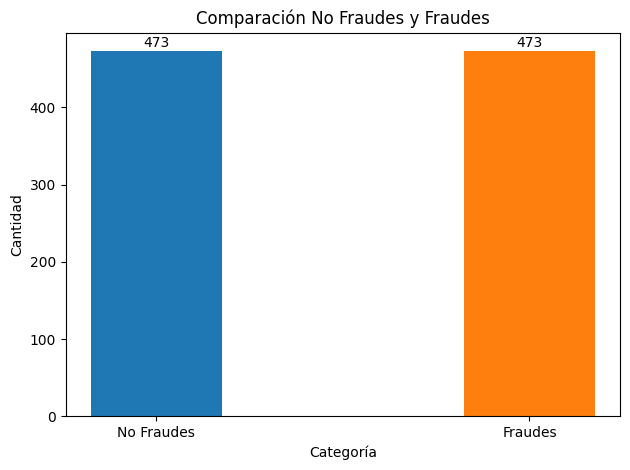

In [18]:
# Gráfica mostrando la cantidad de fraudes y no fraudes
fig, ax = plt.subplots()
bars12 = ax.bar('No Fraudes', len(muestras[muestras['is_fraud'] == 0]), width = 0.35)
bars22 = ax.bar('Fraudes', len(muestras[muestras['is_fraud'] == 1]), width = 0.35)

#ax.set_yscale('log')

ax.bar_label(bars12, labels=[f"{len(muestras[muestras['is_fraud'] == 0])}"], padding=0.5)
ax.bar_label(bars22, labels=[f"{len(muestras[muestras['is_fraud'] == 1])}"], padding=0.5)

ax.set_title('Comparación No Fraudes y Fraudes')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad')

fig.tight_layout()
plt.show()

Después de solucionar el desbalance de los datos, ahora tenemos el mismo número de transacciones fraudulentas que de transacciones no fraudulentas. Ahora se crearán las variables de entrada así como la variable objetivo.

In [19]:
# Variable de entrada
X = np.array(muestras.iloc[:,:-1])
X

array([['7b02919033d6ef7cb7b647739d4ef5c2eae5a0216d70d46a36faf807d725b240',
        31.0, -0.0401706249180779, ..., -1.12101580034497,
        -0.227315111954066, 1.96003546000979],
       ['e2eea5d465528cd8ba49e577714b70a733f56ad4cbe2fd91e2078fec51226762',
        126.0, 0.0230759958268487, ..., 0.138873556754066,
        -0.389982770223192, 1.0012553828295698],
       ['720e1d357d97c74bfa5dfec3c1b60e567459cbb3cc4e237e111c6813ea139b6e',
        0.76, -0.0248992086478594, ..., -3.17888091233286,
        0.573321627839932, 2.06266425952182],
       ...,
       ['b353613b65b6a9caa7285413a8c9a0f9b1d8d2cdad6ff12815a3a1f281db518e',
        3.79, 0.0542542721018558, ..., 0.394684329076182,
        0.8984740237210591, 1.08837493830851],
       ['e4ad01d776e0960c465876b3258849563645452b16eaa4c8a410aff17e2a411d',
        1.0, 0.3594920503605979, ..., -6.31278151817008,
        0.577609830544052, -5.7538519219190505],
       ['39ad4761b77b9e26793f521eabf20a2540437548b53f64b0bc0cf32a9ce7ff34',
  

In [20]:
# Variable de salida/objetivo
y = np.array(muestras.loc[:, 'is_fraud'])

In [21]:
# Split de entrenamiento y prueba
X_train_b, X_test_b, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Seleccionamos todas las columnas menos la primera (se dejó la ID para utilizar en otro código más adelante)
X_train = X_train_b[:, 1:]
X_test = X_test_b[:, 1:]

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (756, 29) (756,)
Test set: (190, 29) (190,)


Después de definir ambas variables, dividimos los datos en 2, una parte serán los datos de entrenamiento y la otra serán los datos de prueba, esto nos ayudará a crear nuestro modelo. Esta división nos ayuda a probar el modelo con datos reales que el modelo no ha visto/procesado, para posteriormente obtener métricas que nos indiquen el desempeño del mismo.

# Data Training

Después de entender y pre-procesar los datos pasamos a la parte de la creación de modelos. Se realizarán dos modelos para ver su comparación entre sí, veremos si hay alguna diferencia significativa al momento de evaluar su desempeño. Primero se creará un modelo usando regresión logística y después otro modelo usando random forest.

In [22]:
# GridSearch para modelo de regresión logística
grid={"C":[0.1, 1, 10, 100], 'penalty':["l2"], 'solver':['liblinear','newton-cg']}
logreg = LogisticRegression()
logreg_cv=GridSearchCV(estimator = logreg, 
                       param_grid = grid,
                       n_jobs=multiprocessing.cpu_count() -1, 
                       scoring = 'accuracy', 
                       error_score = 0)

logreg_cv.fit(X_train, y_train)

# Mejores parámetros
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("best score :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
best score : 0.9417828511676543


In [23]:
# Creación del modelo de regresión logística
lr = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear', max_iter = 1000)
lr.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [24]:
# Búsqueda de parámetros para random forest

# define models and parameters
#model = RandomForestClassifier()
#n_estimators = [10, 100, 1000]
#max_features = ['sqrt', 'log2']
#max_depth=[1, 5, 10, 20]
# define grid search
#grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth = max_depth)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#grid_search = GridSearchCV(estimator=model, 
#                           param_grid=grid, 
#                           n_jobs=multiprocessing.cpu_count() -1, 
#                           cv=cv, 
#                           scoring='accuracy',
#                           error_score=0)
#grid_result = grid_search.fit(X_train, y_train)

In [25]:
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

El código anterior (comentado ya que tarda un poco en correr) arroja el siguiente resultado como los mejores parámetros:

**Best: 0.937415 using {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}**

In [26]:
# Creación de modelo random forest
forest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth = 10)
forest.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=1000)

# Data Testing and Metrics


Teniendo creados y entrenados los modelos, podemos pasar a evaluar su desempeño. Para ellos utilizaremos una matriz de confusión de la cuál obtendremos ciertas métricas, así como otras métricas complementarias.

La matriz de confusión, en pocas palabras, mide 4 posibles resultados:

- True Negative (TN): Número de instancias negativas correctamente clasificadas como negativas.
- False Positive (FP): Número de instancias negativas incorrectamente clasificadas como positivas.
- False Negative (FN): Número de instancias positivas incorrectamente clasificadas como negativas.
- True Positive (TP): Número de instancias positivas correctamente clasificadas como positivas.

Con estos datos, podemos obtener 4 medidas importantes para determinar el desempeño de nuestro modelo. Estas métricas son:


- Accuracy: Porcentaje de aciertos que tuvo el modelo con respecto al total de observaciones.
- Precisión: Es el porcentaje de los estimados positivos que sí fueron positivos, es decir, nos dice qué tan preciso es el modelo prediciendo positivos.
- Recall: Mide cuántas de las instancias realmente positivas fuimos capaces de predecir correctamente, es decir, cuantos positivos reales pudimos detectar.
- F1 Score: Esta medida toma en cuenta tanto la precisión como el recall.

Confusion matrix, without normalization
[[89  4]
 [ 9 88]]


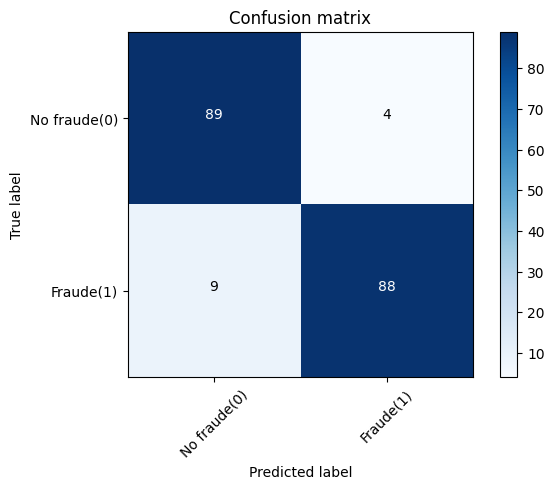

           Accuracy  Precision    Recall  F1 Score
Resultado  0.931579   0.956522  0.907216  0.931217


In [27]:
# Evaluación del modelo de regresión logística
yhat_lr = evaluate_model(X_test, y_test, lr)

Podemos observar que el modelo utilizando regresión logística nos devuelve un:

- 95% de Precision
- 90% de Recall

En pocas palabras, esto quiere decir que nuestro modelo predice positivos con un 95% de precisión. Es decir, si el modelo predijo un positivo, hay un 95% de probabilidad de que sí lo sea. En cuanto al recall, un 90% nos indica que pudimos detectar o "atrapamos" un 90% de los positivos reales, en otras palabras, pudimos detectar un 90% de los fraudes reales.

Ambas medidas, junto con el F1 Score son altas, lo que nos indica que el desempeño del modelo es bueno, sin embargo, todavía falta analizar el AUC.

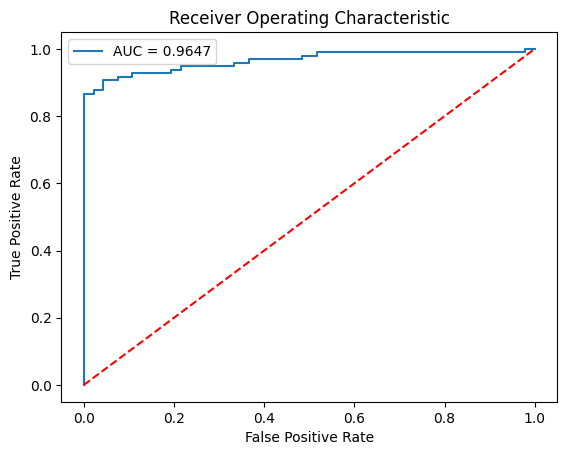

In [28]:
# Función curva ROC regresión logística
AUCROC(X_test, y_test, lr)

Observando la gráfica, un 96% de AUC complementa el buen desempeño que vimos con las métricas anteriores, por lo que este modelo podría considerarse como satisfactorio. Ahora analizaremos el resultado utilizando un modelo de random forest.

Confusion matrix, without normalization
[[93  0]
 [12 85]]


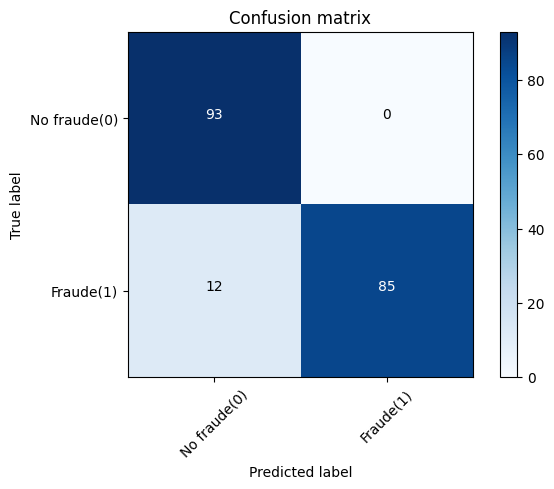

           Accuracy  Precision    Recall  F1 Score
Resultado  0.936842        1.0  0.876289  0.934066


In [29]:
# Evaluación del modelo de random forest
yhat_forest = evaluate_model(X_test, y_test, forest)

Podemos observar que el modelo utilizando random forest nos devuelve un:

- 100% de Precision
- 87% de Recall

Vemos que las medidas no son tan diferentes a la regresión losítica, sin embargo, aquí hay un punto muy importante que mencionar. Primero que nada, una precisión del 100% indica que este modelo detecta bien cuando existe un fraude, es decir, si el modelo predice fraude hay un 100% de probabilidad de que sí lo sea. Sin embargo, un recall menor significaría que no estaríamos detectando todos los fraudes que ocurren o al menos menos que en el modelo pasado.

Lo anterior quiere decir que estamos sacrificando tener más precisión a cambio de un recall menor. ¿Esto qué significa?

Si se utiliza este modelo vamos a tener la habilidad de no equivocarnos al momento de predecir un fraude, haciendo que la satisfacción de nuestros clientes sea buena ya que no habrá casos donde la operación no haya sido fraudulenta y el modelo haya dicho que sí lo fue. A cambio de esto, vamos a perder habilidad al momento de detectar todos los fraudes posibles (debido al recall), o en otras palabras, se nos pasarían algunos fraudes, por lo que la empresa perdería dinero al reponer este dinero de los fraudes cometidos.

En cambio, utilizar el modelo anterior significaria que la empresa no perdería tanto dinero al tener la habilidad de poder detectar más fraudes. Sin embargo, la precisión menor podría afectar la satisfacción de los clientes, ya que habrá ocasiones en donde se detecte una operación como fraudulenta cuando en realidad no lo es. La cuestión aquí sería elegir qué prefiere sacrificar la empresa.


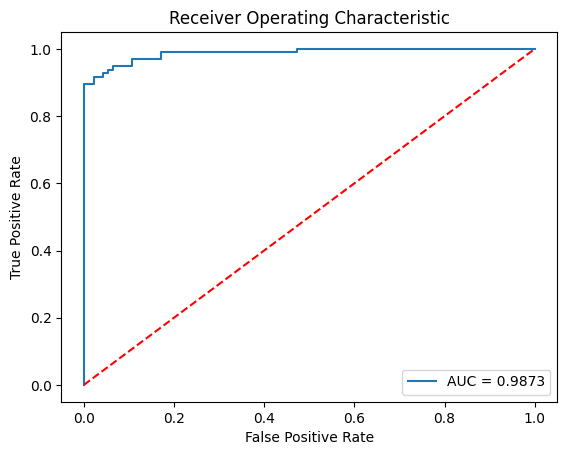

In [30]:
# Función curva ROC regresión logística
AUCROC(X_test, y_test, forest)

Finalmente para este modelo, tenemos un AUC de 98%, medida bastante buena por lo que, junto con las métricas anteriores (incluido el F1 Score alto de 93%), este modelo también puede ser considerado como bueno. 

# Extras


Anteriormente en el notebook se utilizó el método de under-sampling para resolver el problema del desbalance de los datos. De igual manera, se mencionó la posibilidad de utilizar el método SMOTE. Este método no fue utilizado anteriormente ya que, a pesar de conocerlo, nunca lo he utilizado en un caso práctico/código. Por lo tanto, en esta sección se explorará brevemente el funcionamiento de este método.

SMOTE es una técnica de over-sampling donde sea crean nuevas instancias con base en la calse minoritaria y, a diferencia de un over-sampling aleatorio, este algoritmo trata de solucionar el problema de overfitting que se puede derivar de un over-sampling aleatorio.

In [31]:
# Nuevas variables de entrada y salida
X2 = np.array(data.iloc[:,2:-1])
y2 = np.array(data.loc[:, 'is_fraud'])

In [32]:
from imblearn.over_sampling import SMOTE

# Implementar método SMOTE
smote = SMOTE(sampling_strategy = 'minority') 
xx, yy = smote.fit_resample(X2, y2)
pd.Series(yy).value_counts()

0    283253
1    283253
dtype: int64

Se puede observar que el desbalance ya no existe, lo graficaremos.

In [33]:
# Nuevos datos después de aplicar SMOTE
new_data = pd.concat([pd.DataFrame(xx), pd.DataFrame(yy, columns = ['is_fraud'])], axis = 1)
new_data.rename(columns={new_data.columns[0]: 'amount'}, inplace=True)
new_data

,amount,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,is_fraud
0,12.000000,-0.071330,-0.032900,0.109989,0.339889,-0.626131,-0.116853,1.220826,0.394041,0.051705,...,-0.635935,-0.445327,-0.251412,-0.989219,-0.168169,-1.054944,-1.603176,-0.616640,2.283078,0
1,208.890000,0.057858,0.003669,0.076745,0.392782,0.458835,-0.279094,0.435257,0.230350,0.292049,...,2.034140,-0.073293,-0.439827,-0.863551,-1.606923,-1.100937,0.597263,-1.228029,0.875399,0
2,1.000000,-0.002449,0.019520,-0.038565,0.400659,-1.214922,-0.177434,0.303247,0.030461,-0.112687,...,0.561721,-0.351699,0.362076,-1.215083,1.044934,0.533274,-2.802382,0.570268,2.121604,0
3,15.000000,-0.039202,-0.031762,-0.328682,-0.045094,0.606368,0.204822,0.014322,0.013439,0.016800,...,-0.791305,-0.159512,-0.300838,-0.787018,0.020468,-0.853713,-1.915028,-0.478400,2.161957,0
4,0.010000,-0.058206,-0.051926,0.653525,-0.387901,0.806301,0.227390,0.676840,0.209482,-0.206405,...,1.449330,0.141885,-0.854064,-0.347373,-0.750013,-0.914675,-0.595874,-0.705751,2.026529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566501,284.202073,-0.018069,-0.042159,-0.236051,0.061732,-0.565795,0.097009,0.345492,0.203499,0.647903,...,0.178408,-0.267173,1.069458,-0.031677,-0.061165,1.133877,-0.376083,-0.270708,0.283002,1
566502,0.528723,0.743959,-1.265045,-0.187257,0.108958,-0.232261,0.221618,0.028555,0.529645,-0.101328,...,-0.551341,0.514656,-4.331589,-1.280487,-1.708885,4.919983,-3.821074,2.214088,-4.658546,1
566503,1.000000,-1.407553,2.146601,0.651219,-0.169004,-1.040508,1.095331,1.062394,-2.355458,0.994005,...,-6.329679,0.589777,-16.260928,-2.335795,-8.786041,11.881881,-22.420619,8.404917,-15.368304,1
566504,448.066910,0.164227,0.304797,-0.388933,-0.385902,0.013315,0.844284,0.427001,0.618192,0.823618,...,-1.330688,0.589313,0.095488,0.051107,-1.205660,2.512362,-2.673103,0.369486,-1.284129,1


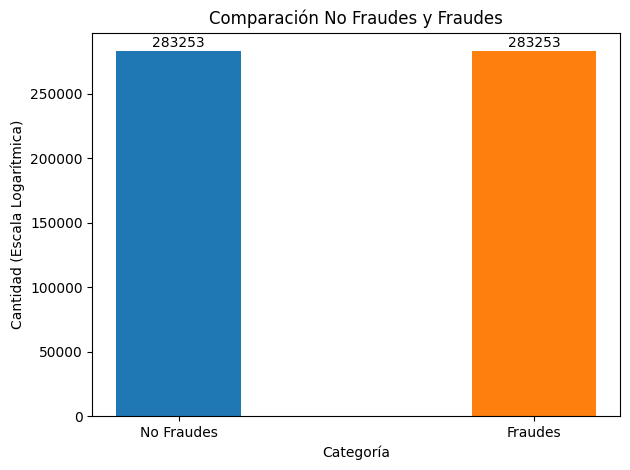

In [34]:
# Gráfica mostrando la cantidad de fraudes y no fraudes
data_fraud2 = new_data[new_data['is_fraud'] == 1]
data_clean2 = new_data[new_data['is_fraud'] == 0]

fig, ax = plt.subplots()
bars1 = ax.bar('No Fraudes', len(data_clean2), width = 0.35)
bars2 = ax.bar('Fraudes', len(data_fraud2), width = 0.35)

#ax.set_yscale('log')

ax.bar_label(bars1, labels=[f'{len(data_clean2)}'], padding=0.5)
ax.bar_label(bars2, labels=[f'{len(data_fraud2)}'], padding=0.5)

ax.set_title('Comparación No Fraudes y Fraudes')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad (Escala Logarítmica)')

fig.tight_layout()
plt.show()

La gráfica anterior confirma que el desbalance de datos ya no existe, ambas clases tienen el mismo número de instancias y, a diferencia de un under-samlping, podemos ver que en este caso las instancias/número de datos son mayores, pasando a ser la clase minoritaría igual al número de datos de la clase mayoritaria. 

De igual manera, existe otro método que en este caso no se utilizó al momento de crear los modelos, el cual es el de escalar los datos. Dicho método se utiliza cuando los rango de los datos son muy diferentes entre sí y se busca "escalarlos" para que sean lo más similares en escala posible. Es decir, podemos escalar cuando una columna tiene números muy pequeños y otra extremadamente grandes. En el caso de estos datos, la única variable que no se parece tanto a las demas es la de "amount". Sin embargo, la diferencia no es tan grande por lo que se decidió no escalar los datos anteriormente. En caso de querer escalarlos, lo haría de la siguiente manera.

In [35]:
# Escalar los datos
scaler = StandardScaler()
new_data['normAmount'] = scaler.fit_transform(new_data[['amount']])
new_data

,amount,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,is_fraud,normAmount
0,12.000000,-0.071330,-0.032900,0.109989,0.339889,-0.626131,-0.116853,1.220826,0.394041,0.051705,...,-0.445327,-0.251412,-0.989219,-0.168169,-1.054944,-1.603176,-0.616640,2.283078,0,-0.370437
1,208.890000,0.057858,0.003669,0.076745,0.392782,0.458835,-0.279094,0.435257,0.230350,0.292049,...,-0.073293,-0.439827,-0.863551,-1.606923,-1.100937,0.597263,-1.228029,0.875399,0,0.407405
2,1.000000,-0.002449,0.019520,-0.038565,0.400659,-1.214922,-0.177434,0.303247,0.030461,-0.112687,...,-0.351699,0.362076,-1.215083,1.044934,0.533274,-2.802382,0.570268,2.121604,0,-0.413894
3,15.000000,-0.039202,-0.031762,-0.328682,-0.045094,0.606368,0.204822,0.014322,0.013439,0.016800,...,-0.159512,-0.300838,-0.787018,0.020468,-0.853713,-1.915028,-0.478400,2.161957,0,-0.358585
4,0.010000,-0.058206,-0.051926,0.653525,-0.387901,0.806301,0.227390,0.676840,0.209482,-0.206405,...,0.141885,-0.854064,-0.347373,-0.750013,-0.914675,-0.595874,-0.705751,2.026529,0,-0.417806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566501,284.202073,-0.018069,-0.042159,-0.236051,0.061732,-0.565795,0.097009,0.345492,0.203499,0.647903,...,-0.267173,1.069458,-0.031677,-0.061165,1.133877,-0.376083,-0.270708,0.283002,1,0.704937
566502,0.528723,0.743959,-1.265045,-0.187257,0.108958,-0.232261,0.221618,0.028555,0.529645,-0.101328,...,0.514656,-4.331589,-1.280487,-1.708885,4.919983,-3.821074,2.214088,-4.658546,1,-0.415756
566503,1.000000,-1.407553,2.146601,0.651219,-0.169004,-1.040508,1.095331,1.062394,-2.355458,0.994005,...,0.589777,-16.260928,-2.335795,-8.786041,11.881881,-22.420619,8.404917,-15.368304,1,-0.413894
566504,448.066910,0.164227,0.304797,-0.388933,-0.385902,0.013315,0.844284,0.427001,0.618192,0.823618,...,0.589313,0.095488,0.051107,-1.205660,2.512362,-2.673103,0.369486,-1.284129,1,1.352309


Al momento de seleccionar las variables de entrada del modelo, se seleccionaría la nueva variable de "normAmount" en lugar de "amount" (junto con los demás features), debido a que esta nueva variable ya está escalada. Esto podría servir para posiblemente mejorar el desempeño del modelo en caso de que este haya sido deficiente.

In [36]:
# Código para obtener el CSV de predicciones de ambos modelos en testing data.

modelsf = pd.DataFrame(data = {'ID': pd.DataFrame(X_test_b).iloc[:,0],
                               'is_fraud': y_test,
                               'is_fraud_lr': yhat_lr,
                               'is_fraud_forest': yhat_forest})
modelsf

,ID,is_fraud,is_fraud_lr,is_fraud_forest
0,ab3443420c3dc833d966e529c1e810f3ea8a663f443f97...,1,1,1
1,1cdced234c1bd08f4be073d7ad8485beeb20fdfcda51ed...,1,1,1
2,8ee45ce17d4f9a2b3dd7b1f5d2f6fb9757954be2e2695d...,1,1,1
3,8c385839af4a9fc0bc2564f62ddbef7a6089ddf60012e8...,0,0,0
4,50216c16e58dff7fa4c0c54fcbe1c426baac7a6284cc96...,0,0,0
...,...,...,...,...
185,424acdaca47b911502b98ae81efce3b70ff7236262ea62...,1,1,1
186,59dfbca7168710ce2556326ed9e96b701f2b83f475b293...,0,0,0
187,084ffbdc8487427e47ad41e736c0e69b92dbc24a9f04fe...,0,0,0
188,d52f04b12b8435fb593bc984dfd0e9a245f3fe87326799...,1,1,1


Como curiosidad, las tablas de abajo representan las predicciones de ambos modelos comparadas con el dato real. Vemos que el modelo 1 en ocasiones predice positivo cuando el valor real es negativo, lo cual coincide con tener una precisión del 95%. De igual manera, podemos ver los casos donde era fraude más no se pudo detectar (esto corresponde al recall).

In [37]:
# Predicción vs real modelo regresión logística
pd.DataFrame([modelsf.iloc[i,0:3] for i in range(len(modelsf)) if modelsf.iloc[i,1] != modelsf.iloc[i,2]])

,ID,is_fraud,is_fraud_lr
23,0655e20fcfc68dd546bdbb781e3e0219af39a2d290981a...,0,1
30,01b9688c1500c59de4557bd7861dff68a222b5b35f22ba...,1,0
33,fb0c25d66166cb92ed329e00767bb30946e3cd69c945ed...,0,1
76,c5a1f9d126e7f115318ca4dcce2ef8d63c52c63421fdd0...,1,0
82,9086ebf70db4fe8e7a284acc28dadd112585f238d389f1...,1,0
97,c2110bf34ac1fc1c9d6a57fecb5a3525665dbc4ed6c8fd...,0,1
116,b4ebe3d189a14c9168042cd834e628b14d60e1cef70d73...,1,0
149,fdbba4a960a0b9473b25a7a6b72f73c318b6f285888535...,1,0
153,a5aa50d2ad6ae3bf5ef8f5532ae24c24689fd4eb6d1c10...,1,0
164,295e021b9667340c9ca34c41d781f2c354517c94dc4598...,1,0


La siguiente tabla, que es del segundo modelo, podemos observar claramente la precisión del 100%, mientras que todos los casos en los que la predicción fue erronea fueron casos en donde el fraude no se pudo detectar (FN), causando un recall ligeramente más bajo.

In [38]:
# Predicción vs real modelo random forest
pd.DataFrame([modelsf.iloc[i,[0,1,3]] for i in range(len(modelsf)) if modelsf.iloc[i,1] != modelsf.iloc[i,3]])

,ID,is_fraud,is_fraud_forest
10,b56262b391d4757bf0fdb84f70f6b5a1cd89b118689c03...,1,0
30,01b9688c1500c59de4557bd7861dff68a222b5b35f22ba...,1,0
46,6dbcb400e87b43db5871693db874c6573250c009f95020...,1,0
59,fb1c5c90112eceb59653e7590eb5f5714382a85f2ae886...,1,0
76,c5a1f9d126e7f115318ca4dcce2ef8d63c52c63421fdd0...,1,0
82,9086ebf70db4fe8e7a284acc28dadd112585f238d389f1...,1,0
149,fdbba4a960a0b9473b25a7a6b72f73c318b6f285888535...,1,0
153,a5aa50d2ad6ae3bf5ef8f5532ae24c24689fd4eb6d1c10...,1,0
164,295e021b9667340c9ca34c41d781f2c354517c94dc4598...,1,0
168,e51c095b7196b0484f04cb424da1fc61f4bf2b419d457e...,1,0


# Conclusiones

A lo largo de este pequeño proyecto, abordamos las etapas para el análisis de datos y la creación de un modelo de Machine Learning, y pudimos darnos cuenta de lo importantes que son todos los pasos/etapas para poder llegar a un modelo adecuado, desde la limpieza y organización de los datos hasta la selección del modelo. Cada factor y decisión influyó en el rendimiento final, y un pequeño cambio en algún método puede tener un impacto en el desempeño final del modelo, por lo que hay que ser cuidadosos al momento de realizar este proceso.

De igual manera, pudimos observar que encontrar el modelo adecuado para el problema va a depender totalmente de los objetivos de dicho modelo y de la empresa. En este caso, la decisión estaría entre darle más importancia a los falsos positivos (precisión) o a los falsos negativos (recall), que en este caso representan darle más importancia a la satisfacción del cliente o a las posibles pérdidas monetarias de la empresa.

En cuanto a poner el modelo en producción y el cuidado del mismo, en lo personal nunca he puesto un modelo en producción, solamente los he evaluado como en este proyecto. Sin embargo, después de una pequeña investigación y por intuición esto es lo que me imagino que se necesita.

Para poner el modelo en producción y asegurarnos de que siga funcionando correctamente a lo largo del tiempo, el primer paso consistiría en el despliegue del modelo, el cual consiste en llevar el modelo a un entorno de producción donde se pueda acceder a datos en tiempo real para poder ser usado por un usuario final. Dentro de este paso, hay aspectos importantes a elegir, como la elección de una plataforma para el despliegue (en la nube) o la creación de un pipeline para automatizar procesos de cambios al modelo.

Una vez desplegado, el modelo debe ser monitoreado constantemente para que su rendimiento sea óptimo y para realizar los ajustes necesarios a lo largo del tiempo. Se pueden realizar evaluaciones del modelo para detectar posibles fallas y pérdida de rendimiento para hacer los ajustes necesarios, así como un monitoreo de las variables de rendimiento del mismo. De igual manera, debemos de asegurarnos de que los datos de entrada o las características no tengan cambios drásticos con el tiempo. Si alguna de estas cambió o se agregó una característica nueva, el modelo se debería actualizar para incluirla y que el rendimiento del modelo no se vea afectado.

Finalmente, algunos aspectos a mejorar del proyecto serían:

- Implementar un tratamiento para los outliers.
- Realizar modelos con la variación del método SMOTE.
- Realizar modelos escalando los datos.
- Crear curvas de aprendizaje para evaluar underfitting y overfitting.
- Ver la importancia de las variables (random forest).
- EDA más profundo.

### Código análisis de deciles y punto de corte (PDF)

In [39]:
# Probabilidades de lr
y_probs = lr.predict_proba(X_test)[:, 1]

# DataFrame con las probabilidades y valores reales
results = pd.DataFrame({
    'real': y_test,
    'probabilidad': y_probs,
})

# Añadir un pequeño ruido a las probabilidades para hacerlas únicas 
# Si no lo hacía solamente obtenía 8 deciles por este "error" de que son únicas
results['probabilidad'] += np.random.normal(0, 1e-10, size=len(results))

# Usar pd.qcut para dividir en 10 grupos
results['decil'] = pd.qcut(results['probabilidad'], 10, labels=False)

# Tabla de análisis de deciles
table = results.groupby('decil').agg(
    frauds=('real', 'sum'), 
    total=('real', 'count'),
    # range_prob=('pred_prob', lambda x: (np.round(np.max(x),3), np.round(np.min(x),3)))
)

table.sort_values(by="decil", ascending=False, inplace=True)
table['fraud_rate'] = table['frauds'] / table['total']
table['cumulative_fraud'] = table['frauds'].cumsum()
table['cumulative_fraud_rate'] = table['cumulative_fraud'] / table['frauds'].sum()
table['lift'] = table['cumulative_fraud_rate'] / (table['total'].cumsum() / table['total'].sum())
table = table.reset_index()
table

,decil,frauds,total,fraud_rate,cumulative_fraud,cumulative_fraud_rate,lift
0,9,19,19,1.000000,19,0.195876,1.958763
1,8,19,19,1.000000,38,0.391753,1.958763
2,7,19,19,1.000000,57,0.587629,1.958763
3,6,19,19,1.000000,76,0.783505,1.958763
4,5,12,19,0.631579,88,0.907216,1.814433
5,4,4,19,0.210526,92,0.948454,1.580756
6,3,2,19,0.105263,94,0.969072,1.384389
7,2,2,19,0.105263,96,0.989691,1.237113
8,1,0,19,0.000000,96,0.989691,1.099656
9,0,1,19,0.052632,97,1.000000,1.000000
